In [1]:
import glob
import os
import omegaconf

import pandas as pd
import numpy as np
import random

import logging

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneGroupOut

import matplotlib.pyplot as plt
import seaborn as sns


logging.basicConfig()
logging.getLogger().setLevel(logging.INFO)


In [2]:
path_champollion = "/neurospin/dico/data/deep_folding/current/models/Champollion_V0"
participants_file = "/neurospin/dico/data/deep_folding/current/datasets/UkBioBank/participants.csv"
embeddings_subpath = "ukb_random_embeddings/full_embeddings.csv"
output_filename = f"{path_champollion}/summary/SexSmallBrain_ukb_without_residualization.csv"
label = "Sex"
max_iter = 2000
cv = 5

In [3]:
def is_it_a_file(sub_dir):
    if os.path.isdir(sub_dir):
        return False
    else:
        logging.debug(f"{sub_dir} is a file. Continue.")
        return True
    

def is_folder_a_model(sub_dir):
    if os.path.exists(sub_dir+'/.hydra/config.yaml'):
        return True
    else:
        logging.debug(f"\n{sub_dir} not associated to a model. Continue")
        return False

def get_model_paths(dir_path, result = None):
    """Recursively gets all models included in dir_path"""
    if result is None:  # create a new result if no intermediate was given
        result = [] 
    for name in os.listdir(dir_path):
        sub_dir = dir_path + '/' + name
        # checks if directory
        if is_it_a_file(sub_dir):
            pass
        elif not is_folder_a_model(sub_dir):
            result.extend(get_model_paths(sub_dir))
        else:
            result.append(sub_dir)
    return result


In [4]:
model_paths = get_model_paths(path_champollion)
embeddings = pd.read_csv(f"{model_paths[0]}/{embeddings_subpath}", index_col=0)
embeddings.head()

,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,dim10,...,dim247,dim248,dim249,dim250,dim251,dim252,dim253,dim254,dim255,dim256
ID,,,,,,,,,,,,,,,,,,,,,
sub-1000021,-16.351534,-18.250902,-61.218895,-31.518833,1.316420,-19.709448,-30.650787,-4.836194,11.724957,-10.719085,...,5.885701,18.859224,60.534985,49.511868,-10.574292,42.713776,-54.271866,-63.233510,2.145985,-0.584021
sub-1000458,78.494545,17.486160,-56.399914,-4.472377,19.620716,12.847065,16.996613,1.623736,15.900013,-18.783915,...,15.319873,37.468906,-45.492126,-31.416237,11.684489,-2.737443,-20.173388,-95.885140,13.359193,12.303552
sub-1000575,14.578348,-1.851342,31.548927,-36.940857,1.321623,-22.691263,-9.321918,11.057373,-4.953552,-18.257122,...,-17.176043,56.603844,-0.758308,19.014345,-14.214785,17.168459,8.057709,-84.404650,14.867142,0.007955
sub-1000606,-12.097008,15.885090,-44.052036,5.630454,-17.983042,-11.990536,-12.911193,45.678677,17.188017,-19.975945,...,-11.762090,-28.175257,17.606665,-35.497850,25.790133,33.244263,1.598719,-55.743290,-0.676654,4.540904
sub-1000963,-45.114950,12.821650,6.196615,24.583563,-39.994450,-26.600460,1.423192,33.193073,1.067284,-23.211040,...,-32.936016,-9.908710,-33.062240,-7.409776,15.760151,4.154897,20.530563,-17.403198,-19.115790,12.229998


In [5]:
participants = pd.read_csv(participants_file, index_col=0)
participants = participants.merge(embeddings, left_index=True, right_index=True)
q_90 = participants["BrainVolumeFreeSurfer_mm3"].quantile(0.9)

In [6]:
participants = participants[participants["BrainVolumeFreeSurfer_mm3"]>=q_90]
participants = participants[["Sex", "BrainVolumeFreeSurfer_mm3"]]
len(participants)

1961

In [7]:
def closest_point(point, points):
    """ Find closest point from a list of points. """
    return np.argsort((points-point)**2)[:10]

In [8]:
participants

,Sex,BrainVolumeFreeSurfer_mm3
sub-4334619,1,1410387.0
sub-1299593,1,1385244.0
sub-2011528,0,1332585.0
sub-5555121,1,1328812.0
sub-2813331,1,1378242.0
...,...,...
sub-4435830,1,1374899.0
sub-2730781,1,1393112.0
sub-4241819,1,1378101.0
sub-1936273,1,1371857.0


In [9]:
females = participants[participants.Sex==0].copy()
males = participants[participants.Sex==1].copy()

males["chosen"] = 0
for one_female in females.iloc[:,1]:
    chosen_rows = closest_point(one_female, males.iloc[:,1])
    for chosen_row in chosen_rows:
        if males.iloc[chosen_row, 2] == 0:
            males.iloc[chosen_row, 2] = 1
            break

participants = pd.concat([females, males[males.chosen==1][["Sex", "BrainVolumeFreeSurfer_mm3"]]])

In [10]:
# participants[participants.Sex==0]["BrainVolumeFreeSurfer_mm3"].hist(bins=100)

In [11]:
# participants[participants.Sex==1]["BrainVolumeFreeSurfer_mm3"].hist(bins=100)

In [12]:
participants = participants[[label]].dropna()

In [13]:
len(participants)

270

In [14]:
# participants.hist()

In [15]:
def compute(model_path):
    # Gets region name
    cfg = omegaconf.OmegaConf.load(model_path+'/.hydra/config.yaml')
    region = cfg['dataset'][next(iter(cfg['dataset']))]['crop_dir'].split('/')[-3]
    side = next(iter(cfg['dataset'])).split('_')[-1]
    region = region + '_' + side
    model_name = model_path.split('/')[-1]
    region_path = '/'.join(model_path.split('/')[-2:])
    print(f"Treating {region}: {region_path} : {model_path}")
    
    # Loads embeddings
    embeddings = pd.read_csv(f"{model_path}/{embeddings_subpath}", index_col=0)
    merged = participants[[label, "folds"]].merge(embeddings, left_index=True, right_index=True)
    
    # Classifies
    X = merged.drop([label, "folds"], axis=1)
    Y = merged[label]
    groups = merged["folds"]
    scaler = StandardScaler()
    X[X.columns] = scaler.fit_transform(X)
    model = LogisticRegression(max_iter=max_iter, random_state=1)
    logo = LeaveOneGroupOut()
    cv = logo.split(X, Y, groups)
    res = cross_val_score(model, X, Y, cv=cv, scoring='roc_auc')
    
    # Gets result
    # roc_auc = roc_auc_score(Y, proba_pred[:,1])
    print(res)
    
    # Returns result
    return (region, res.mean(), res.std(), model_name, region_path, model_path)

In [16]:
def iterative_split_through_sorting_shuffle(df, n_splits, stratify_columns, random_state):
    """Custom iterative train test split which
    maintains balanced representation.
    """
    # Dataframe random row shuffle + sorting according to stratify_columns
    sorted = df.sample(frac=1, random_state=random_state).sort_values(stratify_columns)
    # for each fold, we take one row every n_splits rows
    folds = [sorted.iloc[i::n_splits, :] for i in range(n_splits)]
    # Further shuffling
    folds = [fold.sample(frac=1, random_state=random_state) for fold in folds]
    random.Random(random_state).shuffle(folds)
    return folds

In [17]:
def print_results(parent, folds, col, verbose=True):

    # For each conbination of labels, prints the number of rows for each fold
    # having this combination
    total_errors = 0
    n_splits = len(folds)
    if verbose:
        print("query   : #rows      : #rows per fold\n")

    for col0 in parent[col[0]].unique():
        df = parent.query(f"{col[0]}==@col0")
        len_query = len(df)
        if verbose:
            print(f"{col0}: total = {len_query} : per fold =", end = ' ')
        for fold in folds:
            df0 = fold.query(f"{col[0]}==@col0")
            len_query_fold = len(df0)
            if abs(len_query_fold-len_query/n_splits) >= 2:
                total_errors += 1
            if verbose:
                print(f"{len_query_fold} -", end= ' ')
        if verbose:
            print("")

    # Prints the statistics and the number of stratification errors
    expected_total_length = len(parent)
    total_length = 0
    total_mismatches = 0
    print("\nlengths of folds : ", end = ' ')
    for fold in folds:
        len_fold = len(fold)
        print(len_fold, end=' ')
        total_length += len_fold
        if abs(len_fold-expected_total_length/n_splits) >= 2:
            total_mismatches += 1
    print(f"\nExpected total_length = {expected_total_length}")
    print(f"Effective total_length = {total_length}")

    print(f"total number of stratification errors: {total_errors}")
    print(f"total number of mismatched fold sizes : {total_mismatches}")

In [18]:
folds = iterative_split_through_sorting_shuffle(participants, cv, ['Sex'], 1)

In [19]:
print_results(participants, folds, ["Sex"])

query   : #rows      : #rows per fold

0: total = 135 : per fold = 27 - 27 - 27 - 27 - 27 - 
1: total = 135 : per fold = 27 - 27 - 27 - 27 - 27 - 

lengths of folds :  54 54 54 54 54 
Expected total_length = 270
Effective total_length = 270
total number of stratification errors: 0
total number of mismatched fold sizes : 0


In [20]:
participants["folds"] = -1
for i, fold in enumerate(folds):
    participants.loc[fold.index, "folds"] = i

In [21]:
result = []
for model_path in model_paths:
    result.append(compute(model_path))

Treating S.C.-sylv._left: SC-sylv_left/11-43-38_2 : /neurospin/dico/data/deep_folding/current/models/Champollion_V0/SC-sylv_left/11-43-38_2
[0.75308642 0.63237311 0.64060357 0.62139918 0.42386831]
Treating S.C.-sylv._left: SC-sylv_left/14-00-57_116 : /neurospin/dico/data/deep_folding/current/models/Champollion_V0/SC-sylv_left/14-00-57_116
[0.69958848 0.72290809 0.65569273 0.63786008 0.51440329]
Treating S.F.inter.-S.F.sup._left: SFinter-SFsup_left/09-33-02_0 : /neurospin/dico/data/deep_folding/current/models/Champollion_V0/SFinter-SFsup_left/09-33-02_0
[0.57475995 0.48010974 0.59533608 0.62002743 0.51714678]
Treating S.T.i.-S.T.s.-S.T.pol._right: STi-STs-STpol_right/20-15-00_117 : /neurospin/dico/data/deep_folding/current/models/Champollion_V0/STi-STs-STpol_right/20-15-00_117
[0.56378601 0.5473251  0.51577503 0.64060357 0.46364883]
Treating F.Coll.-S.Rh._right: FColl-SRh_right/09-45-57_1 : /neurospin/dico/data/deep_folding/current/models/Champollion_V0/FColl-SRh_right/09-45-57_1
[0.694

In [22]:
df = pd.DataFrame(result, columns=['region', 'roc_auc', 'roc_auc_std', 'model_name', 'region_path', 'model_path'])

In [23]:
df

,region,roc_auc,roc_auc_std,model_name,region_path,model_path
0,S.C.-sylv._left,0.614266,0.106391,11-43-38_2,SC-sylv_left/11-43-38_2,/neurospin/dico/data/deep_folding/current/mode...
1,S.C.-sylv._left,0.646091,0.072477,14-00-57_116,SC-sylv_left/14-00-57_116,/neurospin/dico/data/deep_folding/current/mode...
2,S.F.inter.-S.F.sup._left,0.557476,0.051491,09-33-02_0,SFinter-SFsup_left/09-33-02_0,/neurospin/dico/data/deep_folding/current/mode...
3,S.T.i.-S.T.s.-S.T.pol._right,0.546228,0.058246,20-15-00_117,STi-STs-STpol_right/20-15-00_117,/neurospin/dico/data/deep_folding/current/mode...
4,F.Coll.-S.Rh._right,0.642524,0.070857,09-45-57_1,FColl-SRh_right/09-45-57_1,/neurospin/dico/data/deep_folding/current/mode...
...,...,...,...,...,...,...
93,S.C.-S.Po.C._left,0.653224,0.116672,16-46-17_3,SC-SPoC_left/16-46-17_3,/neurospin/dico/data/deep_folding/current/mode...
94,S.C.-S.Po.C._left,0.630453,0.102643,16-46-17_0,SC-SPoC_left/16-46-17_0,/neurospin/dico/data/deep_folding/current/mode...
95,S.C.-S.Po.C._left,0.608505,0.102610,14-55-36_0,SC-SPoC_left/14-55-36_0,/neurospin/dico/data/deep_folding/current/mode...
96,S.C.-S.Po.C._left,0.681207,0.100812,16-46-17_1,SC-SPoC_left/16-46-17_1,/neurospin/dico/data/deep_folding/current/mode...


In [24]:
df['side'] = df['region'].str.split('_').str[-1]

In [30]:
def plot_horizontal(res, region_name, ax, AUC_name, std_auc_name, AUC2_name, std_auc2_name, visible, title):
    labelsize=10
    ax.xaxis.set_tick_params(labelsize = labelsize)
    ax.yaxis.set_tick_params(labelsize = labelsize)
    
    res = res.sort_values(by=AUC_name, ascending=True)

    # ax.errorbar(res[AUC_name], res[region_name], res[std_auc_name], fmt='s', color='black')
    # ax.scatter(res[AUC_name], res[region_name], marker='s', color='black')
    ax.axvline(x=0.5, color='black', linestyle='-')
    ax.barh(res[region_name], res[AUC2_name], fill=True, color='lightgray')
    ax.errorbar(res[AUC_name], res[region_name], xerr=0, fmt='s', color='black')
    # if visible:
    #     ax.set_ylabel("AUC ensemble")
    # else:
    #     ax.get_yaxis().set_ticks([])
    ax.set_xlim((0.45, 1.0))
    ax.set_title(title)


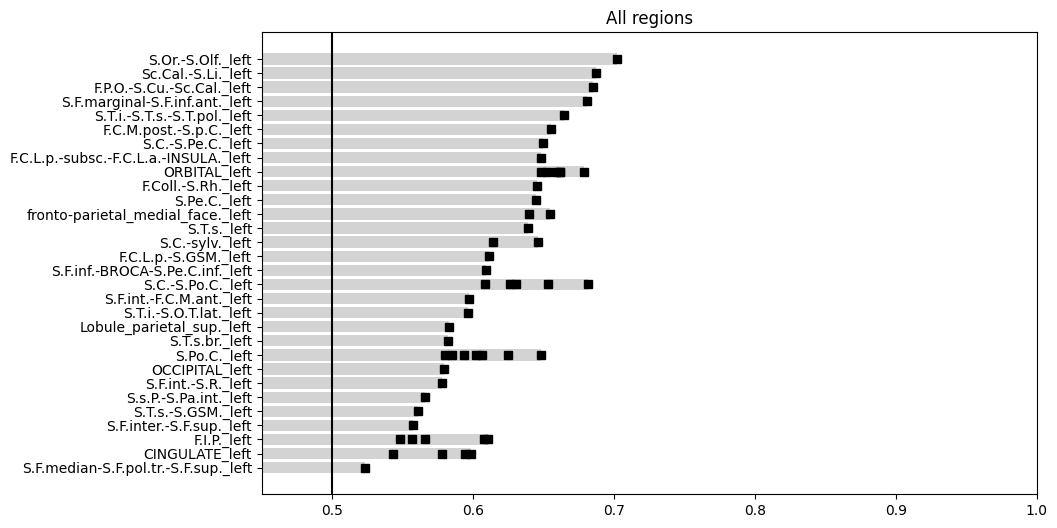

In [31]:
plt.rc('axes', labelsize=12) 
f, ax = plt.subplots(1, 1, figsize=(10, 6))
plot_horizontal(df[df.side=='left'], "region", ax, "roc_auc", "roc_auc_std", "roc_auc", "roc_auc_std", True, "All regions")
plt.show()

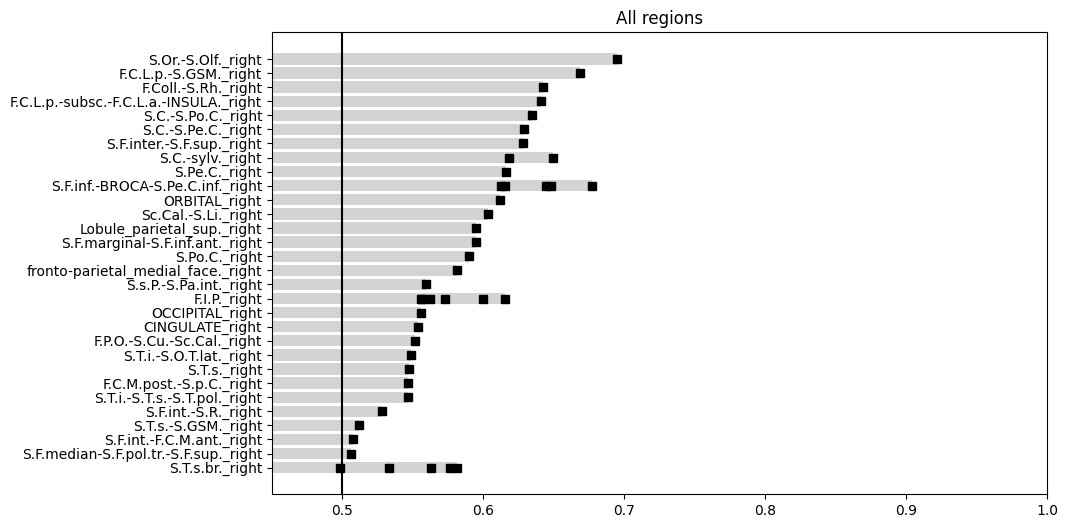

In [32]:
plt.rc('axes', labelsize=12) 
f, ax = plt.subplots(1, 1, figsize=(10, 6))
plot_horizontal(df[df.side=='right'], "region", ax, "roc_auc", "roc_auc_std", "roc_auc", "roc_auc_std", True, "All regions")
plt.show()

In [28]:
df

,region,roc_auc,roc_auc_std,model_name,region_path,model_path,side
0,S.C.-sylv._left,0.614266,0.106391,11-43-38_2,SC-sylv_left/11-43-38_2,/neurospin/dico/data/deep_folding/current/mode...,left
1,S.C.-sylv._left,0.646091,0.072477,14-00-57_116,SC-sylv_left/14-00-57_116,/neurospin/dico/data/deep_folding/current/mode...,left
2,S.F.inter.-S.F.sup._left,0.557476,0.051491,09-33-02_0,SFinter-SFsup_left/09-33-02_0,/neurospin/dico/data/deep_folding/current/mode...,left
3,S.T.i.-S.T.s.-S.T.pol._right,0.546228,0.058246,20-15-00_117,STi-STs-STpol_right/20-15-00_117,/neurospin/dico/data/deep_folding/current/mode...,right
4,F.Coll.-S.Rh._right,0.642524,0.070857,09-45-57_1,FColl-SRh_right/09-45-57_1,/neurospin/dico/data/deep_folding/current/mode...,right
...,...,...,...,...,...,...,...
93,S.C.-S.Po.C._left,0.653224,0.116672,16-46-17_3,SC-SPoC_left/16-46-17_3,/neurospin/dico/data/deep_folding/current/mode...,left
94,S.C.-S.Po.C._left,0.630453,0.102643,16-46-17_0,SC-SPoC_left/16-46-17_0,/neurospin/dico/data/deep_folding/current/mode...,left
95,S.C.-S.Po.C._left,0.608505,0.102610,14-55-36_0,SC-SPoC_left/14-55-36_0,/neurospin/dico/data/deep_folding/current/mode...,left
96,S.C.-S.Po.C._left,0.681207,0.100812,16-46-17_1,SC-SPoC_left/16-46-17_1,/neurospin/dico/data/deep_folding/current/mode...,left


In [29]:
df.to_csv(output_filename)